# Summary

**Summary**
This notebook analyzes trader performance vs BTC market sentiment (Fear/Greed) using historical Hyperliquid data.

## Step 1 – Data Preparation: Load both *datasets*

In [177]:
# Step 1 – Data Preparation: Load both datasets
import pandas as pd

In [178]:
# Load the datasets
historical_df = pd.read_csv("historical_data.csv")

In [179]:
fear_greed_df = pd.read_csv("fear_greed_index.csv")

In [180]:
# Basic info
print("=== Historical Trader Data ===")
print(historical_df.info())
print(historical_df.head())

=== Historical Trader Data ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23285 entries, 0 to 23284
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Account           23285 non-null  object 
 1   Coin              23285 non-null  object 
 2   Execution Price   23285 non-null  float64
 3   Size Tokens       23285 non-null  float64
 4   Size USD          23285 non-null  float64
 5   Side              23285 non-null  object 
 6   Timestamp IST     23285 non-null  object 
 7   Start Position    23285 non-null  float64
 8   Direction         23285 non-null  object 
 9   Closed PnL        23285 non-null  float64
 10  Transaction Hash  23285 non-null  object 
 11  Order ID          23284 non-null  float64
 12  Crossed           23284 non-null  object 
 13  Fee               23284 non-null  float64
 14  Trade ID          23284 non-null  float64
 15  Timestamp         23284 non-null  float64
dtypes: float6

In [181]:
print("\n=== Fear & Greed Index ===")
print(fear_greed_df.info())
print(fear_greed_df.head())


=== Fear & Greed Index ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2644 entries, 0 to 2643
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   timestamp       2644 non-null   int64 
 1   value           2644 non-null   int64 
 2   classification  2644 non-null   object
 3   date            2644 non-null   object
dtypes: int64(2), object(2)
memory usage: 82.8+ KB
None
    timestamp  value classification        date
0  1517463000     30           Fear  2018-02-01
1  1517549400     15   Extreme Fear  2018-02-02
2  1517635800     40           Fear  2018-02-03
3  1517722200     24   Extreme Fear  2018-02-04
4  1517808600     11   Extreme Fear  2018-02-05


## Step 1b – Standardize column names


In [182]:
# Convert column names to lowercase and replace spaces or special chars with underscores
historical_df.columns = (
    historical_df.columns
    .str.strip()
    .str.lower()
    .str.replace(' ', '_')
    .str.replace(r'[^\w]', '_', regex=True)
)

fear_greed_df.columns = (
    fear_greed_df.columns
    .str.strip()
    .str.lower()
    .str.replace(' ', '_')
    .str.replace(r'[^\w]', '_', regex=True)
)

In [183]:
print("=== Historical Trader Data columns ===")
print(historical_df.columns.tolist())


=== Historical Trader Data columns ===
['account', 'coin', 'execution_price', 'size_tokens', 'size_usd', 'side', 'timestamp_ist', 'start_position', 'direction', 'closed_pnl', 'transaction_hash', 'order_id', 'crossed', 'fee', 'trade_id', 'timestamp']


In [184]:
print("\n=== Fear & Greed Index columns ===")
print(fear_greed_df.columns.tolist())


=== Fear & Greed Index columns ===
['timestamp', 'value', 'classification', 'date']


## Step 1c – Convert timestamps into proper datetime objects

## For Historical Trader Data

In [185]:
# If it has both 'timestamp' (epoch) and 'timestamp_ist' (string), we’ll handle both
if 'timestamp' in historical_df.columns:
    historical_df['timestamp'] = pd.to_datetime(historical_df['timestamp'], unit='s', errors='coerce')

if 'timestamp_ist' in historical_df.columns:
    historical_df['timestamp_ist'] = pd.to_datetime(historical_df['timestamp_ist'], errors='coerce')

In [186]:
# Create a unified trade_date column (YYYY-MM-DD)
if 'timestamp_ist' in historical_df.columns and historical_df['timestamp_ist'].notna().sum() > 0:
    historical_df['trade_date'] = historical_df['timestamp_ist'].dt.date
else:
    historical_df['trade_date'] = historical_df['timestamp'].dt.date

## For Fear & Greed Index

In [187]:
# If it has 'timestamp' (epoch) or 'date' string, handle accordingly
if 'timestamp' in fear_greed_df.columns:
    fear_greed_df['timestamp'] = pd.to_datetime(fear_greed_df['timestamp'], unit='s', errors='coerce')

if 'date' in fear_greed_df.columns:
    fear_greed_df['date'] = pd.to_datetime(fear_greed_df['date'], errors='coerce').dt.date

In [188]:
print("=== Historical Trader Data with trade_date ===")
print(historical_df[['timestamp', 'timestamp_ist', 'trade_date']].head())

=== Historical Trader Data with trade_date ===
  timestamp       timestamp_ist  trade_date
0       NaT 2024-02-12 22:50:00  2024-02-12
1       NaT 2024-02-12 22:50:00  2024-02-12
2       NaT 2024-02-12 22:50:00  2024-02-12
3       NaT 2024-02-12 22:50:00  2024-02-12
4       NaT 2024-02-12 22:50:00  2024-02-12


In [189]:
print("\n=== Fear & Greed Index with date ===")
print(fear_greed_df[['timestamp', 'date']].head())



=== Fear & Greed Index with date ===
            timestamp        date
0 2018-02-01 05:30:00  2018-02-01
1 2018-02-02 05:30:00  2018-02-02
2 2018-02-03 05:30:00  2018-02-03
3 2018-02-04 05:30:00  2018-02-04
4 2018-02-05 05:30:00  2018-02-05


In [190]:
# Check what columns exist after standardization
print(historical_df.columns.tolist())


['account', 'coin', 'execution_price', 'size_tokens', 'size_usd', 'side', 'timestamp_ist', 'start_position', 'direction', 'closed_pnl', 'transaction_hash', 'order_id', 'crossed', 'fee', 'trade_id', 'timestamp', 'trade_date']


## Step 1d – Extract trade_date (already done in Step 1c) and merge with sentiment date

In [191]:
# Ensure both merge keys are the same type
historical_df['trade_date'] = pd.to_datetime(historical_df['trade_date'])
fear_greed_df['date'] = pd.to_datetime(fear_greed_df['date'])

In [192]:
# Select only the relevant columns from Fear & Greed
fear_greed_df_small = fear_greed_df[['date', 'classification']].copy()
fear_greed_df_small.rename(columns={'classification': 'sentiment'}, inplace=True)

In [193]:
# Merge historical trades with sentiment data
merged_df = pd.merge(
    historical_df,
    fear_greed_df_small,
    how='left',
    left_on='trade_date',
    right_on='date'
)

In [194]:
# Drop duplicate 'date' column (now that it's merged)
merged_df.drop(columns=['date'], inplace=True)

In [195]:
print("=== Merged Data Sample ===")
print(merged_df[['trade_date', 'sentiment', 'closed_pnl']].head())

=== Merged Data Sample ===
  trade_date sentiment  closed_pnl
0 2024-02-12     Greed         0.0
1 2024-02-12     Greed         0.0
2 2024-02-12     Greed         0.0
3 2024-02-12     Greed         0.0
4 2024-02-12     Greed         0.0


In [196]:
# Check if any trades don't have a matching sentiment
missing_sentiment_count = merged_df['sentiment'].isna().sum()
print(f"\nTrades without matching sentiment: {missing_sentiment_count}")



Trades without matching sentiment: 18466


In [197]:
import os

# Create the folder if it doesn't exist
os.makedirs("csv_files", exist_ok=True)

# Save merged file
merged_df.to_csv("csv_files/processed_trades.csv", index=False)
print("✅ Merged file saved to csv_files/processed_trades.csv")


✅ Merged file saved to csv_files/processed_trades.csv


## Step 1e – Merge trades with sentiment

In [198]:
# Ensure both keys are datetime
historical_df['trade_date'] = pd.to_datetime(historical_df['trade_date'])
fear_greed_df['date'] = pd.to_datetime(fear_greed_df['date'])

In [199]:
# Keep only required sentiment columns
fear_greed_df_small = fear_greed_df[['date', 'classification']].copy()
fear_greed_df_small.rename(columns={'classification': 'sentiment'}, inplace=True)

In [200]:
# Merge (left join: keep all trades)
merged_df = pd.merge(
    historical_df,
    fear_greed_df_small,
    how='left',
    left_on='trade_date',
    right_on='date'
)


In [201]:
# Drop duplicate 'date' from right side
merged_df.drop(columns=['date'], inplace=True)

In [202]:
# Preview merged result
print("=== Merged Data Sample ===")
print(merged_df[['trade_date', 'sentiment', 'closed_pnl']].head())

=== Merged Data Sample ===
  trade_date sentiment  closed_pnl
0 2024-02-12     Greed         0.0
1 2024-02-12     Greed         0.0
2 2024-02-12     Greed         0.0
3 2024-02-12     Greed         0.0
4 2024-02-12     Greed         0.0


In [203]:
# Count missing sentiment matches
missing_sentiment_count = merged_df['sentiment'].isna().sum()
print(f"\nTrades without matching sentiment: {missing_sentiment_count}")


Trades without matching sentiment: 18466


In [204]:
# Save merged file for future use
merged_df.to_csv("csv_files/processed_trades.csv", index=False)


# Step 2 – Feature Engineering

In [205]:
# 1. Profit (already Closed PnL)
merged_df['profit'] = merged_df['closed_pnl']

In [206]:
# 2. is_win flag
merged_df['is_win'] = (merged_df['profit'] > 0).astype(int)

In [207]:
# 3. abs_leverage and leverage bins
# Since your dataset has no leverage column, we set it to NaN or estimate later if possible
merged_df['abs_leverage'] = None  # Placeholder for now

In [208]:
# Create leverage bins only if leverage exists
if 'leverage' in merged_df.columns:
    merged_df['abs_leverage'] = merged_df['leverage'].abs()
    merged_df['leverage_bin'] = pd.cut(
        merged_df['abs_leverage'],
        bins=[0, 2, 5, 10, 25, 50, 100, float('inf')],
        labels=['≤2x', '2–5x', '5–10x', '10–25x', '25–50x', '50–100x', '>100x']
    )
else:
    merged_df['leverage_bin'] = 'Unknown'

In [209]:
# 4. trade_value_usd
if 'size_usd' in merged_df.columns:
    merged_df['trade_value_usd'] = merged_df['size_usd']
elif 'execution_price' in merged_df.columns and 'size_tokens' in merged_df.columns:
    merged_df['trade_value_usd'] = merged_df['execution_price'] * merged_df['size_tokens']
else:
    merged_df['trade_value_usd'] = None

In [210]:
# 5. trade_hour and day_of_week
if 'timestamp_ist' in merged_df.columns and merged_df['timestamp_ist'].notna().sum() > 0:
    merged_df['trade_hour'] = pd.to_datetime(merged_df['timestamp_ist']).dt.hour
    merged_df['day_of_week'] = pd.to_datetime(merged_df['timestamp_ist']).dt.day_name()
elif 'timestamp' in merged_df.columns:
    merged_df['trade_hour'] = pd.to_datetime(merged_df['timestamp']).dt.hour
    merged_df['day_of_week'] = pd.to_datetime(merged_df['timestamp']).dt.day_name()
else:
    merged_df['trade_hour'] = None
    merged_df['day_of_week'] = None

In [211]:
# Preview new features
print(merged_df[['trade_date', 'sentiment', 'profit', 'is_win', 'abs_leverage',
                 'leverage_bin', 'trade_value_usd', 'trade_hour', 'day_of_week']].head())


  trade_date sentiment  profit  is_win abs_leverage leverage_bin  \
0 2024-02-12     Greed     0.0       0         None      Unknown   
1 2024-02-12     Greed     0.0       0         None      Unknown   
2 2024-02-12     Greed     0.0       0         None      Unknown   
3 2024-02-12     Greed     0.0       0         None      Unknown   
4 2024-02-12     Greed     0.0       0         None      Unknown   

   trade_value_usd  trade_hour day_of_week  
0          7872.16        22.0      Monday  
1           127.68        22.0      Monday  
2          1150.63        22.0      Monday  
3          1142.04        22.0      Monday  
4            69.75        22.0      Monday  


In [212]:
# Save updated file
import os
os.makedirs("csv_files", exist_ok=True)
merged_df.to_csv("csv_files/processed_trades_with_features.csv", index=False)
print("✅ Saved: csv_files/processed_trades_with_features.csv")


✅ Saved: csv_files/processed_trades_with_features.csv


#Step 3 – Analysis

In [213]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Create outputs folder
os.makedirs("outputs", exist_ok=True)

=== Avg Closed PnL by Sentiment ===
       sentiment      profit
0   Extreme Fear    0.000000
1  Extreme Greed -113.061391
2           Fear  477.347680
3          Greed   14.377992
4        Neutral  171.217109


/tmp/ipython-input-2083440124.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_pnl_by_sentiment, x='sentiment', y='profit', palette='viridis')


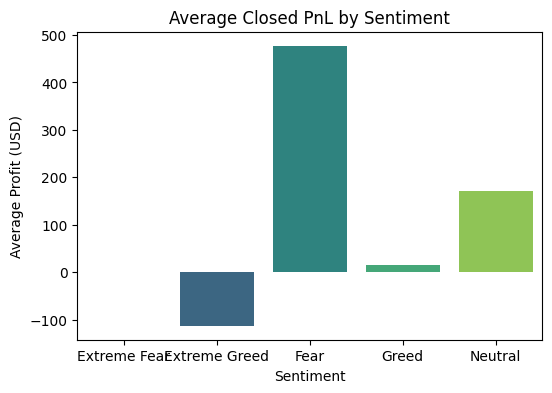

In [214]:
# 1. Avg Closed PnL by sentiment
avg_pnl_by_sentiment = merged_df.groupby('sentiment')['profit'].mean().reset_index()
print("=== Avg Closed PnL by Sentiment ===")
print(avg_pnl_by_sentiment)

plt.figure(figsize=(6,4))
sns.barplot(data=avg_pnl_by_sentiment, x='sentiment', y='profit', palette='viridis')
plt.title("Average Closed PnL by Sentiment")
plt.ylabel("Average Profit (USD)")
plt.xlabel("Sentiment")
plt.savefig("outputs/avg_pnl_by_sentiment.png", dpi=300)


=== Win Rate (%) by Sentiment ===
       sentiment     is_win
0   Extreme Fear   0.000000
1  Extreme Greed  22.123894
2           Fear  43.526700
3          Greed  38.102085
4        Neutral  48.750000


/tmp/ipython-input-2651473946.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=win_rate_by_sentiment, x='sentiment', y='is_win', palette='magma')


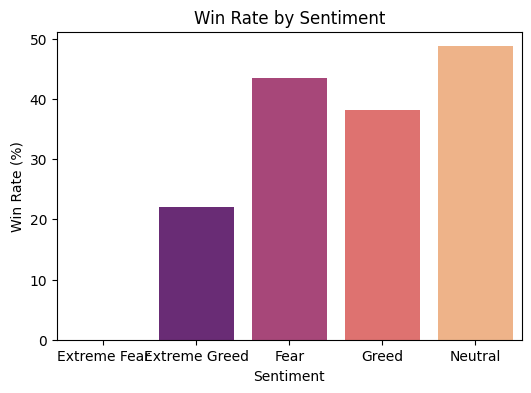

In [215]:
# 2. Win rate by sentiment
win_rate_by_sentiment = merged_df.groupby('sentiment')['is_win'].mean().reset_index()
win_rate_by_sentiment['is_win'] *= 100
print("\n=== Win Rate (%) by Sentiment ===")
print(win_rate_by_sentiment)

plt.figure(figsize=(6,4))
sns.barplot(data=win_rate_by_sentiment, x='sentiment', y='is_win', palette='magma')
plt.title("Win Rate by Sentiment")
plt.ylabel("Win Rate (%)")
plt.xlabel("Sentiment")
plt.savefig("outputs/win_rate_by_sentiment.png", dpi=300)

In [216]:
# 3. Avg leverage by sentiment (only if leverage data exists)
if 'abs_leverage' in merged_df.columns and merged_df['abs_leverage'].notna().sum() > 0:
    avg_lev_by_sentiment = merged_df.groupby('sentiment')['abs_leverage'].mean().reset_index()
    print("\n=== Avg Leverage by Sentiment ===")
    print(avg_lev_by_sentiment)

    plt.figure(figsize=(6,4))
    sns.barplot(data=avg_lev_by_sentiment, x='sentiment', y='abs_leverage', palette='coolwarm')
    plt.title("Average Leverage by Sentiment")
    plt.ylabel("Average Leverage")
    plt.xlabel("Sentiment")
    plt.savefig("outputs/avg_leverage_by_sentiment.png", dpi=300)
    plt.close()
else:
    print("\nNo leverage data found – skipping leverage analysis.")


No leverage data found – skipping leverage analysis.



=== Trade Volume & USD Amount by Sentiment ===
       sentiment  total_trades  total_trade_value_usd
0   Extreme Fear            67              213184.14
1  Extreme Greed           678             4299319.33
2           Fear          2603            39578035.68
3          Greed          1391            19673035.20
4        Neutral            80              876754.39


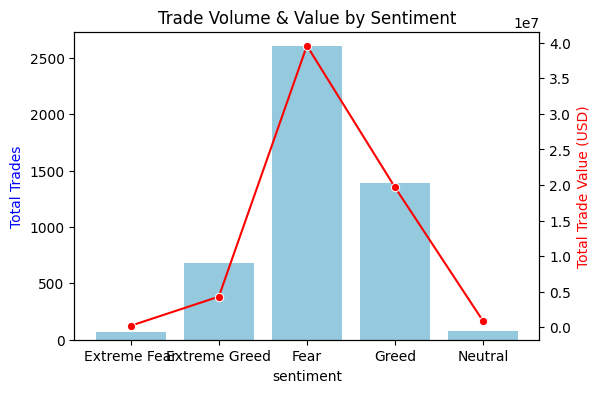

In [217]:
# 4. Trade volume & USD amount by sentiment
volume_usd_by_sentiment = merged_df.groupby('sentiment').agg(
    total_trades=('account', 'count'),
    total_trade_value_usd=('trade_value_usd', 'sum')
).reset_index()
print("\n=== Trade Volume & USD Amount by Sentiment ===")
print(volume_usd_by_sentiment)

fig, ax1 = plt.subplots(figsize=(6,4))
sns.barplot(data=volume_usd_by_sentiment, x='sentiment', y='total_trades', color='skyblue', ax=ax1)
ax1.set_ylabel("Total Trades", color='blue')
ax2 = ax1.twinx()
sns.lineplot(data=volume_usd_by_sentiment, x='sentiment', y='total_trade_value_usd', color='red', marker='o', ax=ax2)
ax2.set_ylabel("Total Trade Value (USD)", color='red')
plt.title("Trade Volume & Value by Sentiment")
plt.savefig("outputs/trade_volume_value_by_sentiment.png", dpi=300)

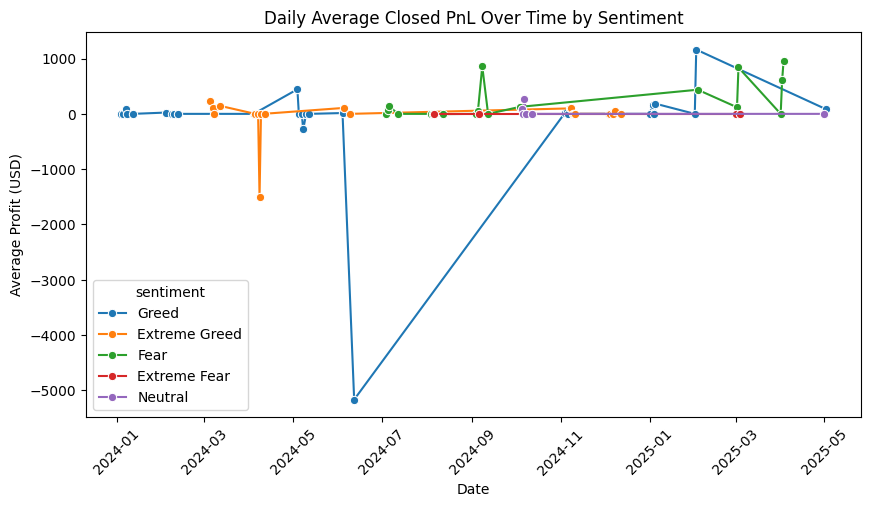

In [218]:

# 5. Time series plots (Daily Avg Profit)
daily_avg_pnl = merged_df.groupby(['trade_date', 'sentiment'])['profit'].mean().reset_index()

plt.figure(figsize=(10,5))
sns.lineplot(data=daily_avg_pnl, x='trade_date', y='profit', hue='sentiment', marker='o')
plt.title("Daily Average Closed PnL Over Time by Sentiment")
plt.ylabel("Average Profit (USD)")
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.savefig("outputs/daily_avg_pnl_over_time.png", dpi=300)
